In [39]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix


Подключение к БД

In [40]:
db = sqlite3.connect('../data/checking-logs.sqlite')


## create a dataframe where each user of the test group has the average difference, number of pageviews and number of commits

Запрос для получения числа просмотров из таблицы pageviews

In [41]:
query = '''
SELECT uid, COUNT(*) AS num_views
FROM pageviews
WHERE uid LIKE 'user_%'
GROUP BY uid
'''
pageviews = pd.io.sql.read_sql(query, db)
pageviews

,uid,num_views
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


Запрос для получения числа коммитов из таблицы checker

In [42]:
query = '''
SELECT uid, COUNT(*) AS num_commits
FROM checker
WHERE uid LIKE 'user_%'
AND labname != 'project1'
GROUP BY uid
'''
commits = pd.io.sql.read_sql(query, db)
commits

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


Запрос для получения среднего значения разницы между дедлайном и временем первого коммита из таблицы deadlines

In [43]:
views_diff_query = """
SELECT
    test.uid AS uid,
    AVG(cast((julianday(datetime(deadlines.deadlines, 'unixepoch')) - julianday(test.first_commit_ts)) * 24 as integer)) AS avg_diff
    
FROM
    test
INNER JOIN
    deadlines
ON
    test.labname = deadlines.labs
WHERE
    test.labname != 'project1'
GROUP BY
    test.uid;
"""
views_diff = pd.io.sql.read_sql(views_diff_query, db)
views_diff


,uid,avg_diff
0,user_1,64.400000
1,user_10,74.800000
2,user_11,2.000000
3,user_12,89.000000
4,user_13,48.500000
5,user_14,159.000000
6,user_15,17.500000
7,user_16,39.333333
8,user_17,61.600000
9,user_18,5.666667


Создадим сводную таблицу, в которую войдут число коммитов, число просмотров и разница между дедлайном и временем первого коммита из таблицы deadlines  для каждого uid

In [44]:
pivot_table = pageviews.merge(commits, on=['uid'])
pivot_table = views_diff.merge(pivot_table, on=['uid'])
pivot_table = pivot_table.drop(columns = ['uid'])
pivot_table

,avg_diff,num_views,num_commits
0,64.400000,28,62
1,74.800000,89,20
2,159.000000,143,61
3,61.600000,47,51
4,5.666667,3,5
5,98.750000,16,118
6,95.500000,10,65
7,92.600000,179,79
8,86.400000,149,60
9,105.400000,317,18


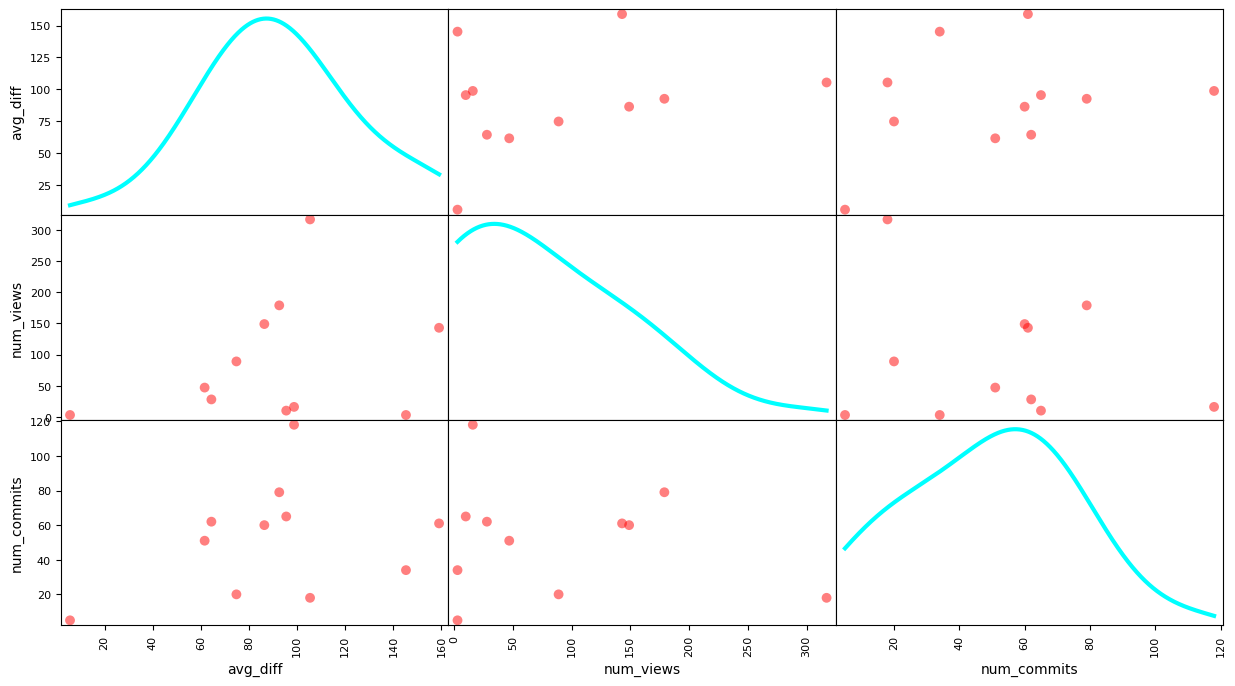

In [45]:
ax = scatter_matrix(pivot_table,
                    figsize=(15, 8),
                    diagonal='kde', #На диагонали отображается ядерная оценка плотности (Kernel Density Estimate).
                    density_kwds=dict(color='cyan', linewidth=3),
                    s=200, #размер точек на диаграммах
                    color='red')

In [46]:
db.close()

## «Можно ли сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него мало и коммитов?»

Ответ: Нет

## «Можем ли мы сказать, что если у пользователя мало просмотров страниц, то у него, скорее всего, небольшая средняя разница между первым коммитом и крайним сроком выполнения лабораторных работ?» 

Ответ: Нет

## «Можем ли мы сказать, что есть много пользователей с малым количеством коммитов и несколько с большим количеством коммитов»? 

Ответ: Нет?

## «Можно ли сказать, что есть много пользователей с небольшой средней разницей и несколько с большой средней разницей»

Нет